In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Rectangle

import requests
from io import StringIO as sio

import baltic as bt
import numpy as np

address='https://github.com/sdwfrost/mers-treedater/raw/master/MERS_274_sCoal.combinedTyped.mcc.tree' ## where the tree we'll use lives

fetch_tree = requests.get(address) ## fetch tree
treeFile=sio(fetch_tree.text) ## stream from repo copy

ll=bt.loadNexus(treeFile) ## treeFile here can alternatively be a path to a local file

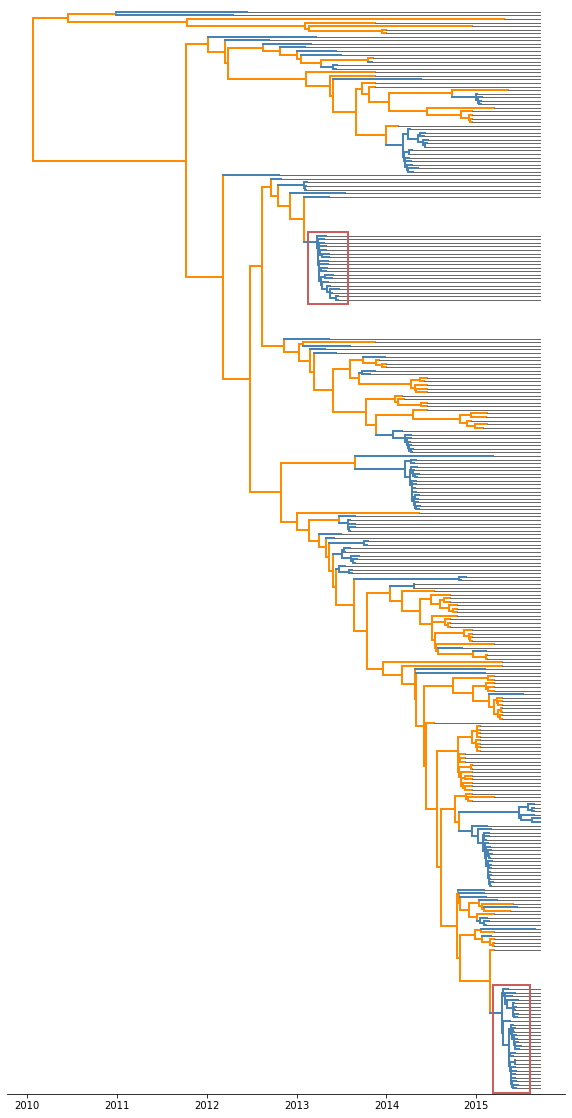

In [2]:
fig = plt.figure(figsize=(10, 20),facecolor='w') ## create figure
gs = gridspec.GridSpec(1,1,wspace=0.0) ## using gridspec by default
ax=plt.subplot(gs[0],facecolor='w') ## create axes

host_is_human=lambda k: k.traits['type']=='h' ## return true if branch is in humans
host_colour=lambda k: 'steelblue' if host_is_human(k) else 'darkorange' ## colour blue if human and orange otherwise

same_host=lambda k: 'type' in k.parent.traits and k.parent.traits['type']==k.traits['type'] ## branch is in same host as parent branch

highlights=ll.getBranches(lambda w: 'type' in w.parent.traits and w.traits['type']!=w.parent.traits['type']) ## get branches where parental and descendant branches are in different hosts

pad_nodes={} ## dict of branch: padding amount for branches chosen for highlighting
for node in highlights: ## iterate over branches chosen for highlighting
    if node.is_leaf() or len(node.leaves)<=18: ## if branch is a tip or a node with fewer than 18 descendants
        pad_nodes[node]=0 ## don't pad
    else:
        pad_nodes[node]=10 ## otherwise pad by 10

ll.drawTree(pad_nodes=pad_nodes) ## redraw tree with new padding

host_is_human=lambda k: k.traits['type']=='h' ## return true if branch is in humans
host_colour=lambda k: 'steelblue' if host_is_human(k) else 'darkorange' ## colour blue if human and orange otherwise

ll.plotTree(ax,x_attr=lambda k: k.absoluteTime,colour=host_colour) ## draw tree, with absolute time and colour

for k in ll.getExternal(): ## iterate over tips
    ax.plot([k.absoluteTime,ll.mostRecent],[k.y,k.y],ls='-',lw=1,color='dimgrey') ## grey lines from every tip's date to the most recent date

for k in highlights: ## iterate over highlights again
    if pad_nodes[k]>0: ## if node was padded
        xpad=0.1 ## space left along x axis
        ypad=1.2 ## space left along y axis
        height=max(k.yRange)-min(k.yRange)+ypad*2 if k.is_node() else ypad*2 ## box height is the extremes of y coordinates of node's descendants

        left=k.absoluteTime-xpad ## left side of box is node's date minus padding

        lower=min(k.yRange)-ypad if k.is_node() else k.y-ypad ## lower side of box is lowest coordinate minus padding

        width=k.childHeight-k.height+xpad*2 if k.is_node() else xpad*2 ## box width is difference between node height and last descendant

        rect=Rectangle((left,lower),width,height,facecolor='none',edgecolor='indianred',lw=2,ls='-',zorder=100) ## create rectangle
        ax.add_patch(rect) ## add rectangle to plot

ax.set_yticks([]) ## no y ticks
ax.set_yticklabels([])
[ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['bottom']] ## no spines

ax.set_ylim(-1,ll.ySpan+1)
plt.show()